# Probability weighted Autoencoder
A Probability-Weighted Autoencoder (PWAE) is a variant of the traditional autoencoder designed to incorporate probabilistic weighting into the reconstruction process. Unlike standard autoencoders that treat all inputs equally, a PWAE assigns different importance to each data point based on its probability distribution, enhancing its ability to detect anomalies and rare events. The model minimizes a weighted reconstruction loss, ensuring that more critical samples (e.g., minority class instances like fraud) contribute more to learning.

In [5]:
from river import compose, preprocessing, metrics, datasets
from deep_river.anomaly import ProbabilityWeightedAutoencoderInitialized
from torch import nn, manual_seed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skrub import TableReport

## Analyse
This code initializes a reproducible environment and loads a subset of the CreditCard dataset, selecting 5000 transactions for analysis. It then converts the dataset into a Pandas DataFrame and generates a summary report using TableReport(), which provides an overview of the dataset's structure, feature distributions, and potential missing values. This step helps to understand the data before applying preprocessing or modeling techniques.

In [6]:
_ = manual_seed(42)
dataset = datasets.CreditCard().take(5000)
TableReport(pd.DataFrame([x for x, _ in dataset]))

Processing column  30 / 30


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Model Creation
While the model stays the same as the fully connected autoencoder, the wrapper class changes to the probability weighted autoencoder. 

In [7]:
dataset = datasets.CreditCard().take(5000)
metric = metrics.RollingROCAUC(window_size=5000)
class MyAutoEncoder(nn.Module):
    def __init__(self, n_features, latent_dim=3):
        super(MyAutoEncoder, self).__init__()
        self.linear1 = nn.Linear(n_features, latent_dim)
        self.nonlin = nn.LeakyReLU()
        self.linear2 = nn.Linear(latent_dim, n_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X, **kwargs):
        X = self.linear1(X)
        X = self.nonlin(X)
        X = self.linear2(X)
        return self.sigmoid(X)


model_pipeline = compose.Pipeline(
    preprocessing.MinMaxScaler(), 
    ProbabilityWeightedAutoencoderInitialized(module=MyAutoEncoder(30), lr=0.005)
)
model_pipeline

/Users/cedrickulbach/Documents/Projects/deep-river/deep_river/anomaly/probability_weighted_ae.py:201: UserWarning: This is deprecated and will be removed in future releases. Please instead use the AutoencoderInitialized class and initialize the module beforehand
  warnings.warn(


Pipeline (
  MinMaxScaler (),
  ProbabilityWeightedAutoencoderInitialized (
    module=MyAutoEncoder(
    (linear1): Linear(in_features=30, out_features=3, bias=True)
    (nonlin): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=3, out_features=30, bias=True)
    (sigmoid): Sigmoid()
  )
    loss_fn="mse"
    optimizer_fn="sgd"
    lr=0.005
    device="cpu"
    seed=42
    skip_threshold=0.9
    window_size=250
  )
)

## Run the Datastream
This block performs hyperparameter optimization by evaluating the impact of different latent dimensions on the model's performance. It iterates over a predefined set of `latent_dim` values, initializing a fresh dataset and rolling ROC AUC metric for each experiment. A pipeline is created for each latent dimension, consisting of a `MinMaxScaler` for normalization and an autoencoder trained using online learning. The model is then trained and evaluated sequentially on the dataset, updating the metric with its predictions. After processing all data points, the final ROC AUC score is recorded for the current latent dimension. Once all experiments are completed, the results are stored in a DataFrame and visualized using a line plot, where the x-axis represents the latent dimension values and the y-axis represents the corresponding ROC AUC scores. This visualization helps identify the optimal latent dimension for anomaly detection.

In [8]:
for x, y in dataset:
    score = model_pipeline.score_one(x)
    metric.update(y_true=y, y_pred=score)
    model_pipeline.learn_one(x=x)
print(f"ROCAUC: {metric.get():.4f}")

ROCAUC: 0.8530


## Hyperparameter Optimization
This block processes the dataset sequentially, evaluating and updating the model in an online learning manner. For each data point, the model generates an anomaly score using `score_one(x)`, which is then used to update the rolling ROC AUC metric by comparing it to the true label `y`. After scoring, the model is trained incrementally using `learn_one(x)`, allowing it to adapt continuously as new data arrives. Once all data points have been processed, the final ROC AUC score is printed, providing a performance measure of the model's ability to distinguish between fraudulent and non-fraudulent transactions.

In [9]:
latent_dims = [2, 5, 10, 20, 30, 40]  # You can adjust this range
results = []

/Users/cedrickulbach/Documents/Projects/deep-river/deep_river/anomaly/probability_weighted_ae.py:201: UserWarning: This is deprecated and will be removed in future releases. Please instead use the AutoencoderInitialized class and initialize the module beforehand
  warnings.warn(


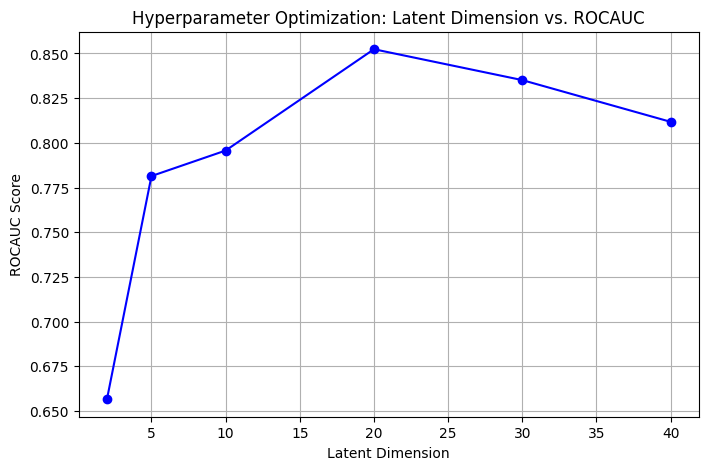

In [10]:
for latent_dim in latent_dims:
    # Initialize a fresh metric
    dataset = datasets.CreditCard().take(5000)
    metric = metrics.RollingROCAUC(window_size=5000)

    # Initialize pipeline with current latent_dim
    model_pipeline = compose.Pipeline(
        preprocessing.MinMaxScaler(),
        ProbabilityWeightedAutoencoderInitialized(module=MyAutoEncoder(30, latent_dim), lr=0.005)
    )

    # Train and evaluate model
    for x, y in dataset:
        score = model_pipeline.score_one(x)
        metric.update(y_true=y, y_pred=score)
        model_pipeline.learn_one(x=x)

    # Store the result
    results.append((latent_dim, metric.get()))

# Convert results to DataFrame for visualization
df_results = pd.DataFrame(results, columns=["latent_dim", "ROCAUC"])

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(df_results["latent_dim"], df_results["ROCAUC"], marker="o", linestyle="-", color="b")
plt.xlabel("Latent Dimension")
plt.ylabel("ROCAUC Score")
plt.title("Hyperparameter Optimization: Latent Dimension vs. ROCAUC")
plt.grid(True)
plt.show()